Copyright (c) 2025 Mitsuru Ohno  
Use of this source code is governed by a BSD-3-style  
license that can be found in the LICENSE file.  

## 使用方法の要約
基本的な使用: RxnIVPsolv("sample_data.csv")でインスタンス化  
数値積分: get_ode_system()で必要なオブジェクトを取得  
エラーハンドリング: try-except文でエラーをキャッチ  
可視化: matplotlibで結果をプロット  
パラメータ解析: 異なる初期条件での比較  
これらの使用例は、現在のコードが正しく動作することを前提としています。もしエラーが発生した場合は、debug_ode_system()メソッドで詳細な情報を確認できます。  

## 反応式を記載したcsvファイルを指定する  

In [1]:
file_path = '../sample_data/sample_data_1.csv'  # CSVファイルのパスを指定

In [2]:
# development phase
# Add the parent directory (one level up from the notebook's location) to the Python path
import os
import sys

sys.path.append(os.path.join(os.getcwd(), '..'))

## 数値積分を実行する場合  

In [4]:
from dataclasses import dataclass, field
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
# from rxnfit.build_ode import RxnODEbuild
from src.rxnfit.build_ode import RxnODEbuild

In [4]:
# 作成した微分方程式に関する情報を表示
def get_ode_info(rxn_ivp, debug_info=False):    
    print(f"number of species: {len(rxn_ivp.function_names)}")
    print(f"unique species: {rxn_ivp.function_names}")
    print(f"rate constant: {rxn_ivp.rate_consts_dict}")

    if debug_info is True:
        # デバッグ情報を確認
        print("\n=== debug info ===")
        debug_info = rxn_ivp.debug_ode_system()
        print(f"order of args: {debug_info['lambdify_args']}")
        print(f"system of ODE: {debug_info['ode_expressions']}")

In [5]:
@dataclass
class SolverConfig:
    rxn_ivp: RxnODEbuild
    y0: list              # 初期濃度（必須）
    t_span: tuple         # 時間範囲（必須）
    t_eval: Optional[np.ndarray] = field(default=None)  # 任意
    method: str = "RK45"  # 任意
    rtol: float = 1e-6    # 任意

In [6]:
def solve_system(config: SolverConfig):

    # 数値積分に必要なオブジェクトを取得
    ode_construct = rxn_ivp_build.get_ode_system()
    (system_of_equations, sympy_symbol_dict, 
     ode_system, function_names, rate_consts_dict) = ode_construct
    
    # 微分方程式の右辺を定義
    def system_rhs(t, y):
        """ODEシステムの右辺を計算する関数"""
        rhs_odesys = []
        for i, species_name in enumerate(function_names):
            if species_name in ode_system:
                try:
                    rhs_odesys.append(ode_system[species_name](t, *y))
                except Exception as e:
                    print(f"Error in {species_name}: {e}")
                    rhs_odesys.append(0.0)
            else:
                rhs_odesys.append(0.0)
        return rhs_odesys
    
    # 数値積分を実行
    #print("\n=== 数値積分の実行 ===")
    solution = None
    try:
        solution = solve_ivp(
            system_rhs, 
            config.t_span, 
            config.y0, 
            t_eval=config.t_eval,
            method='RK45'
        )
        #print("数値積分が成功しました！")
    except Exception as e:
        print(f"数値積分でエラーが発生しました: {e}")
        print("デバッグ情報を確認してください。")
    return ode_construct, solution


In [7]:
# 結果をプロット
def solution_plot(function_names, solution):
    print("\n=== 結果のプロット ===")
    plt.figure(figsize=(12, 8))
    
    for i, species_name in enumerate(function_names):
        plt.plot(solution.t, solution.y[i], label=species_name, linewidth=2)
    
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Concentration', fontsize=12)
    plt.title('Chemical Reaction Kinetics - Sample Data', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 最終時刻での濃度を表示
    print("\n=== 最終時刻での濃度 ===")
    final_concentrations = {name: conc[-1] for name, conc in zip(function_names, solution.y)}
    for name, conc in final_concentrations.items():
        print(f"{name}: {conc:.6f}")
        


In [8]:
# 基本的な数値積分 -インスタンス化-
rxn_ivp_build = RxnODEbuild(file_path)

In [9]:
# 使い方例
rxn_ivp_build = RxnODEbuild(file_path)
get_ode_info(rxn_ivp_build, debug_info=True)

number of species: 8
unique species: ['AcOEt', 'OHa1', 'AcOa1', 'EtOH', 'AcOiPr', 'iPrOH', 'EGOAc2', 'EG']
rate constant: {'k1': 0.054, 'k2': 0.044, 'k3': 0.031}

=== debug info ===
Successfully created function for AcOEt with args: ['t', 'AcOEt', 'OHa1', 'AcOa1', 'EtOH', 'AcOiPr', 'iPrOH', 'EGOAc2', 'EG']
Successfully created function for OHa1 with args: ['t', 'AcOEt', 'OHa1', 'AcOa1', 'EtOH', 'AcOiPr', 'iPrOH', 'EGOAc2', 'EG']
Successfully created function for AcOa1 with args: ['t', 'AcOEt', 'OHa1', 'AcOa1', 'EtOH', 'AcOiPr', 'iPrOH', 'EGOAc2', 'EG']
Successfully created function for EtOH with args: ['t', 'AcOEt', 'OHa1', 'AcOa1', 'EtOH', 'AcOiPr', 'iPrOH', 'EGOAc2', 'EG']
Successfully created function for AcOiPr with args: ['t', 'AcOEt', 'OHa1', 'AcOa1', 'EtOH', 'AcOiPr', 'iPrOH', 'EGOAc2', 'EG']
Successfully created function for iPrOH with args: ['t', 'AcOEt', 'OHa1', 'AcOa1', 'EtOH', 'AcOiPr', 'iPrOH', 'EGOAc2', 'EG']
Successfully created function for EGOAc2 with args: ['t', 'AcOE

In [10]:
# 初期値等の入力項目を渡す
config = SolverConfig(
    rxn_ivp=rxn_ivp_build, 
    y0=[1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    t_span=(0, 10)
)

In [11]:
rxn_ivp_build.rate_consts_dict['k1']+3

3.054

In [12]:
intedrated_result = solve_system(config)
intedrated_result

Successfully created function for AcOEt with args: ['t', 'AcOEt', 'OHa1', 'AcOa1', 'EtOH', 'AcOiPr', 'iPrOH', 'EGOAc2', 'EG']
Successfully created function for OHa1 with args: ['t', 'AcOEt', 'OHa1', 'AcOa1', 'EtOH', 'AcOiPr', 'iPrOH', 'EGOAc2', 'EG']
Successfully created function for AcOa1 with args: ['t', 'AcOEt', 'OHa1', 'AcOa1', 'EtOH', 'AcOiPr', 'iPrOH', 'EGOAc2', 'EG']
Successfully created function for EtOH with args: ['t', 'AcOEt', 'OHa1', 'AcOa1', 'EtOH', 'AcOiPr', 'iPrOH', 'EGOAc2', 'EG']
Successfully created function for AcOiPr with args: ['t', 'AcOEt', 'OHa1', 'AcOa1', 'EtOH', 'AcOiPr', 'iPrOH', 'EGOAc2', 'EG']
Successfully created function for iPrOH with args: ['t', 'AcOEt', 'OHa1', 'AcOa1', 'EtOH', 'AcOiPr', 'iPrOH', 'EGOAc2', 'EG']
Successfully created function for EGOAc2 with args: ['t', 'AcOEt', 'OHa1', 'AcOa1', 'EtOH', 'AcOiPr', 'iPrOH', 'EGOAc2', 'EG']
Successfully created function for EG with args: ['t', 'AcOEt', 'OHa1', 'AcOa1', 'EtOH', 'AcOiPr', 'iPrOH', 'EGOAc2', '

(([Eq(Derivative(AcOEt(t), t), -0.054*AcOEt(t)*OHa1(t)),
   Eq(Derivative(OHa1(t), t), -0.054*AcOEt(t)*OHa1(t) - 0.044*AcOiPr(t)*OHa1(t) - 0.062*EGOAc2(t)*OHa1(t)**2),
   Eq(Derivative(AcOa1(t), t), 0.054*AcOEt(t)*OHa1(t) + 0.044*AcOiPr(t)*OHa1(t) + 0.062*EGOAc2(t)*OHa1(t)**2),
   Eq(Derivative(EtOH(t), t), 0.054*AcOEt(t)*OHa1(t)),
   Eq(Derivative(AcOiPr(t), t), -0.044*AcOiPr(t)*OHa1(t)),
   Eq(Derivative(iPrOH(t), t), 0.044*AcOiPr(t)*OHa1(t)),
   Eq(Derivative(EGOAc2(t), t), -0.031*EGOAc2(t)*OHa1(t)**2),
   Eq(Derivative(EG(t), t), 0.031*EGOAc2(t)*OHa1(t)**2)],
  {'t': t,
   'Derivative': sympy.core.function.Derivative,
   'k1': 0.054,
   'k2': 0.044,
   'k3': 0.031,
   'AcOEt': AcOEt,
   'OHa1': OHa1,
   'AcOa1': AcOa1,
   'EtOH': EtOH,
   'AcOiPr': AcOiPr,
   'iPrOH': iPrOH,
   'EGOAc2': EGOAc2,
   'EG': EG},
  {'AcOEt': <function _lambdifygenerated(t, AcOEt, OHa1, AcOa1, EtOH, AcOiPr, iPrOH, EGOAc2, EG)>,
   'OHa1': <function _lambdifygenerated(t, AcOEt, OHa1, AcOa1, EtOH, AcOiPr,


=== 結果のプロット ===


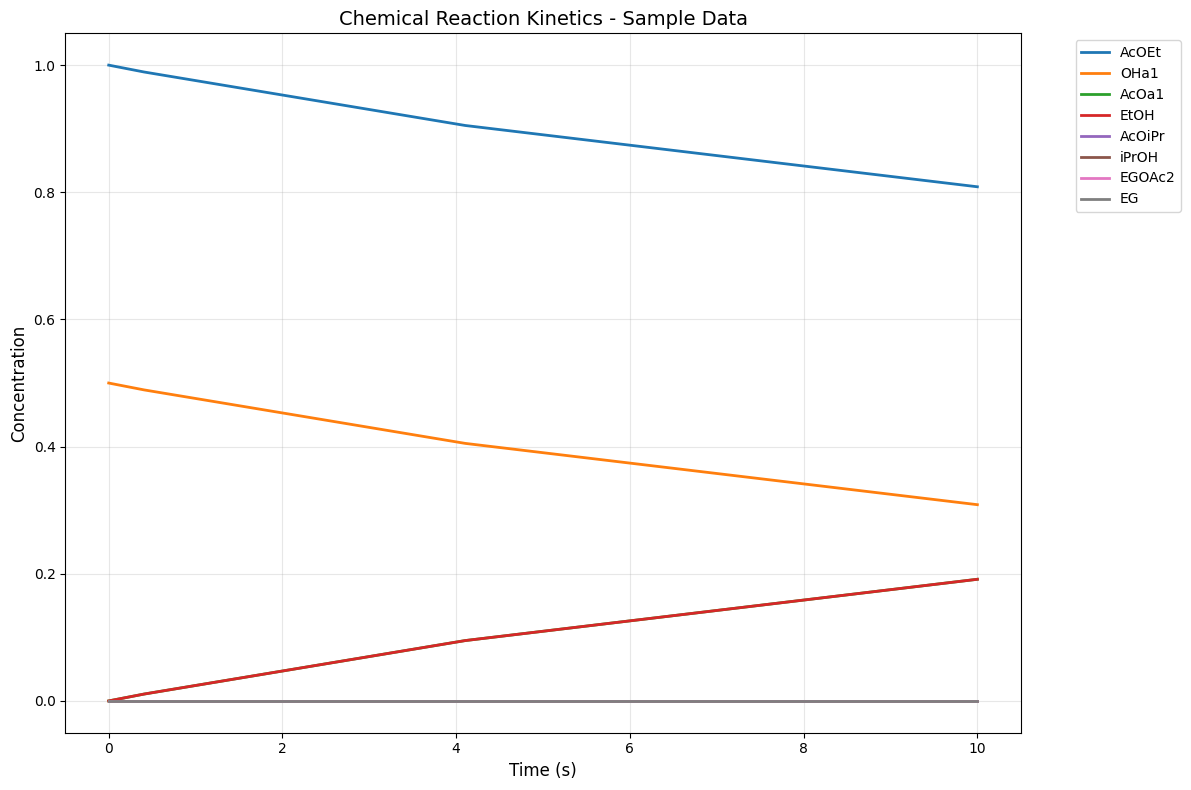


=== 最終時刻での濃度 ===
AcOEt: 0.808657
OHa1: 0.308657
AcOa1: 0.191343
EtOH: 0.191343
AcOiPr: 0.000000
iPrOH: 0.000000
EGOAc2: 0.000000
EG: 0.000000


In [13]:
solution_plot(rxn_ivp_build.function_names,intedrated_result[1])

## フィッティングさせる  

In [14]:
file_path = '../sample_data/sample_time_course_2.csv'  # CSVファイルのパスを指定

In [15]:
import numpy as np
import pandas as pd

In [16]:
df = pd.read_csv(file_path)
l = ['t', 'AcOEt', 'H2O', 'AcOH', 'EtOH']
df = df[l]
df

,t,AcOEt,H2O,AcOH,EtOH
0,5.13,NaN,NaN,0.000,NaN
1,12.95,NaN,NaN,0.019,NaN
2,18.15,NaN,NaN,0.045,NaN
3,29.08,NaN,NaN,0.073,NaN
4,40.18,NaN,NaN,0.101,NaN
5,51.15,NaN,NaN,0.132,NaN
6,61.70,NaN,NaN,0.161,NaN
7,74.75,NaN,NaN,0.185,NaN
8,91.33,NaN,NaN,0.221,NaN
9,106.58,NaN,NaN,0.246,NaN


In [17]:
rxn_ivp_build.function_names

['AcOEt', 'OHa1', 'AcOa1', 'EtOH', 'AcOiPr', 'iPrOH', 'EGOAc2', 'EG']